In [1]:
import math
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

Using this data, build a regression model to predict property crimes. You can use the features you prepared in the previous assignment, new features of your own choosing, or a combination. The goal here is prediction rather than understanding mechanisms, so the focus is on creating a model that explains a lot of variance.

Submit a notebook with your model and a brief writeup of your feature engineering and selection process to submit and review with your mentor.

## Cleaning and Inspecting the Data.

In [2]:
# Access the data file from the FBI: UCR 
dataset = pd.read_excel("NYCCrime.xls", header=4)

In [3]:
# Change the dataset into a DataFrame
data = pd.DataFrame(dataset)

In [4]:
# Access the Columns desired for this challenge
data_group = data.loc[:, ['City', 'Population', 'Property\ncrime', 'Robbery', 'Burglary', 'Larceny-\ntheft', 'Arson3']]

In [5]:
# Rename the group columns
data_group.columns = ['City', 'Population', 'Property_crime', 'Robbery', 'Burglary', 'Theft', 'Arson']

In [6]:
# Change the Arson null values to 0. 
data_group.Arson = np.nan_to_num(data_group.Arson)

In [7]:
# Drop the remaining null values in every column. 
data_group = data_group.dropna(axis=0, how='any')

In [8]:
# Function to remove outlier data
def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

In [9]:
# Filter the continuous variables through the outlier removal function and then drop the null values. 
for group in data_group.loc[:, 'Population':]:
    data_group[group] = reject_outliers(data_group[group], m=2)
data_group = data_group.dropna()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


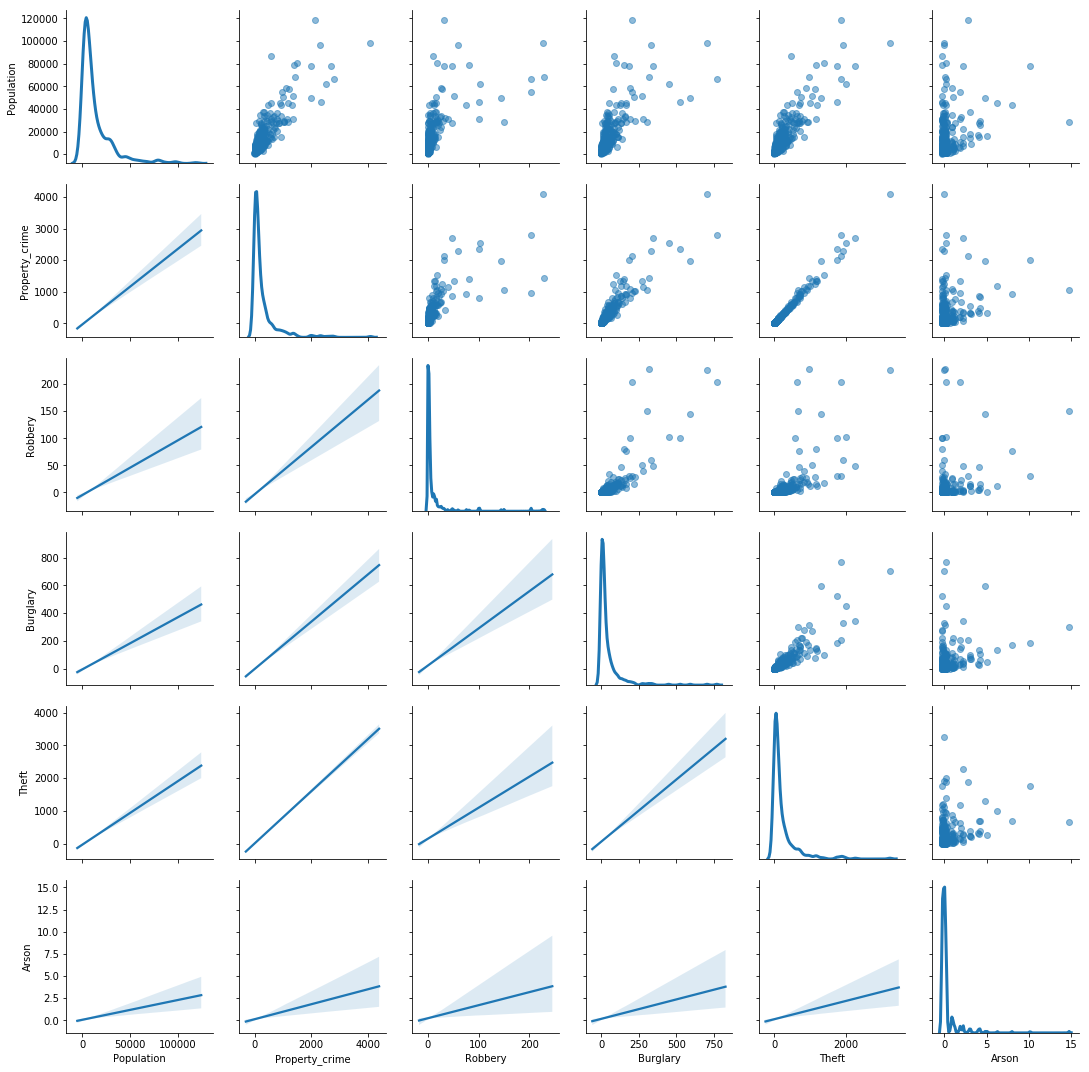

In [10]:
# Make a graph displaying the relationship of each of the continuous variables to each other. 
new_data = data_group.loc[:, 'Population':]

# Making the random noise.
jitter = pd.DataFrame(
    np.random.uniform(-.3, .3, size=(new_data.shape)),
    columns=new_data.columns
)
# Combine the data and the noise.
new_data = new_data.add(jitter)

# Declare that you want to make a scatterplot matrix.
g = sns.PairGrid(new_data.dropna(), diag_sharey=False)
# Scatterplot.
g.map_upper(plt.scatter, alpha=.5)
# Fit line summarizing the linear relationship of the two variables.
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
# Give information about the univariate distributions of the variables.
g.map_diag(sns.kdeplot, lw=3)
plt.show()

## My Multivariable Linear Regression Model

To demonstrate, that my model accurately predicts property crimes I'm going to show how it meets thet the four assumptions of multivariable linear regression models. 

### Assumption one: linear relationship

I chose four features that had the clearest linear relationship with the target of property crime. 

In [11]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = data_group['Property_crime'].values.reshape(-1, 1)
X = data_group[['Theft', 'Burglary', 'Robbery', 'Population']]
regr.fit(X, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

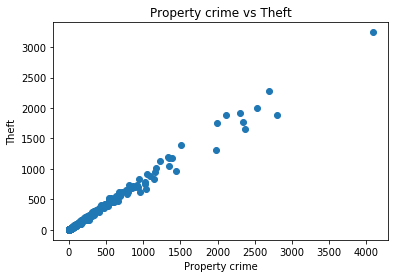

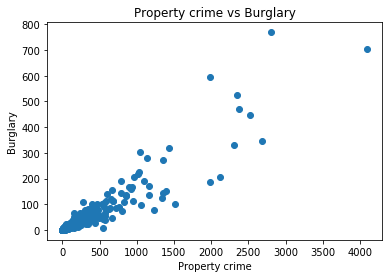

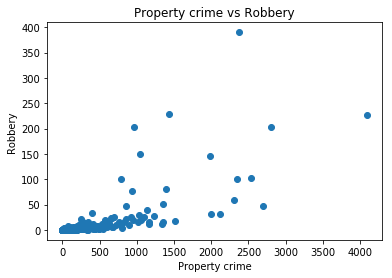

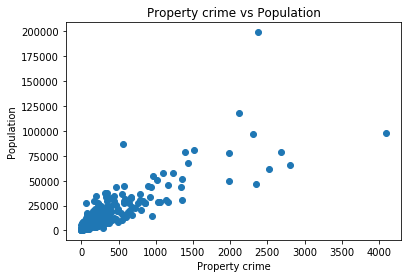

In [12]:
for each in X:
    plt.scatter(data_group['Property_crime'], data_group[each])
    plt.title('Property crime vs ' + each)
    plt.xlabel('Property crime')
    plt.ylabel(each)
    plt.show()

### Assumption two: multivariate normality

The error from my model should be and is normally distributed.

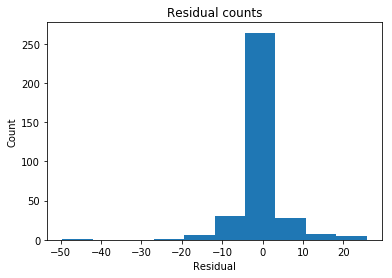

In [13]:
predicted = regr.predict(X).ravel()
actual = data_group['Property_crime']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

### Assumption three: homoscedasticity

The distribution of my error terms (its "scedasticity"), should be consistent for all predicted values, or homoscedastic. Overall, my error terms range between -20 and 20 for values between 500 and 4000 with one outlier. 

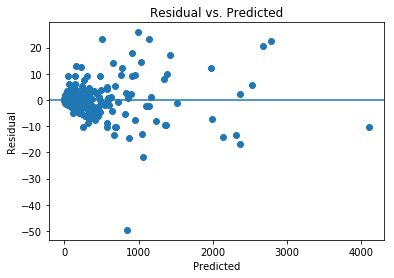

In [14]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

### Assumption four: low multicollinearity

This appears to be the weakest part of my model because my feature correlation is moderate to high. However, since my only goal is prediction, all that matters is that the variance gets explained.

In [15]:
correlation_matrix = X.corr()
display(correlation_matrix)

,Theft,Burglary,Robbery,Population
Theft,1.000,0.879,0.661,0.834
Burglary,0.879,1.000,0.808,0.735
Robbery,0.661,0.808,1.000,0.727
Population,0.834,0.735,0.727,1.000


## Checking for Overfitting

I'm going to see if my results change by checking my model with training and test groups. 

In [16]:
# Test my model with different holdout groups.
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
data_train, data_test, target_train, target_test = train_test_split(X, Y, test_size=0.30, random_state=42)

my_model = regr.fit(data_train, target_train)

# Classify, storing the result in a training variable and Fit our model to the data.
train_pred = my_model.predict(data_train)

# Display our Training results.
print('\nTraining Coefficients: \n', regr.coef_)
print('\nTraining Intercept: \n', regr.intercept_)
print('\nTraining R-squared:')
training_score = r2_score(train_pred, target_train)
print(training_score)

# Classify, storing the result in a testing variable and Fit our model to the data.
test_pred = my_model.predict(data_test)

print('\nTesting R-squared:')
score = r2_score(test_pred, target_test)
print(score)


Training Coefficients: 
 [[  1.00841083e+00   1.01342677e+00   4.85585897e-01   1.33795743e-04]]

Training Intercept: 
 [-0.47606445]

Training R-squared:
0.999829446717

Testing R-squared:
0.999916471113


As you can see, even when splitting up my dataset into training and testing groups, the accuracy remains consistent for both groups. 

### Recreating the Model using statsmodels

In [17]:
linear_formula = 'Property_crime ~ Theft+Burglary+Robbery+Population'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=data_group).fit()

Looking again at the coefficients of my model.

In [18]:
lm.params

Intercept    -0.334
Theft         1.005
Burglary      1.019
Robbery       0.475
Population    0.000
dtype: float64

Now measuring the p-values as a significance test for each of the coefficients.

In [19]:
lm.pvalues

Intercept    0.424
Theft        0.000
Burglary     0.000
Robbery      0.000
Population   0.000
dtype: float64

And lastly I want the error estimates, called the confidence intervals, which give the range of values within which our population parameter is likely to fall.

In [20]:
lm.conf_int()

,0,1
Intercept,-1.155,0.486
Theft,1.000,1.009
Burglary,1.000,1.039
Robbery,0.438,0.512
Population,0.000,0.000


## Validating My Model With Another Dataset

To make sure a model has good predictive validity for new data, it is necessary to assess the performance of the model on new datasets.

We'll use the property crime model you've been working on with, based on the FBI:UCR data. Since your model formulation to date has used the entire New York State 2013 dataset, you'll need to validate it using some of the other crime datasets available at the FBI:UCR website. Options include other states crime rates in 2013 or crime rates in New York State in other years or a combination of these.

In [21]:
# Loading the NYC 2014 crime rates as my new dataset.
dataset2 = pd.read_excel("NYCCrime_2014.xls", header=4)
# Change the dataset2 into a DataFrame
data2 = pd.DataFrame(dataset2)
# Access the same columns that I used for validating my model.
data_group2 = data2.loc[:, ['Population', 'Property\ncrime', 'Robbery', 'Burglary', 'Larceny-\ntheft']]
# Renaming the data2 group columns
data_group2.columns = ['Population', 'Property_crime', 'Robbery', 'Burglary', 'Theft']
# Drop the remaining null values in every column. 
data_group2 = data_group2.dropna(axis=0, how='any')

In [23]:
# The Y value or target feature of the model.
target = data_group2['Property_crime'].values.reshape(-1, 1)
# The new dataset needs to be arranged in the same order that the model dataset was organized. 
new_dataset = data_group2[['Theft', 'Burglary', 'Robbery', 'Population']]
# Storing the predicted results from the new dataset in a variable.
validate = my_model.predict(new_dataset)
print('\nValidating the model with new dataset')
print('\nNew Dataset R-squared value:')
# Comparing those predicted results to the actual 'Property Crime' values from the new dataset
score2 = r2_score(validate, target)
print(score2)
#print(regr.score(new_dataset, target))


Validating the model with new dataset

New Dataset R-squared value:
0.999639438261
